# Размещение баннеров
Представим, что международное круизное агентство Carnival Cruise Line решило себя разрекламировать с помощью баннеров и обратилось для этого к вам. Чтобы протестировать, велика ли от таких баннеров польза, их будет размещено всего 20 штук по всему миру. Вам надо выбрать 20 таких локаций для размещения, чтобы польза была большой и агентство продолжило с вами сотрудничать.

Агентство крупное, и у него есть несколько офисов по всему миру. Вблизи этих офисов оно и хочет разместить баннеры — легче договариваться и проверять результат. Также эти места должны быть популярны среди туристов.

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift

Для поиска оптимальных мест воспользуемся базой данных крупнейшей социальной сети, основанной на локациях — Foursquare.

Часть открытых данных есть, например, на сайте archive.org:
https://archive.org/details/201309_foursquare_dataset_umn

Скачаем любым удобным образом архив fsq.zip с этой страницы.
Нас будет интересовать файл checkins.dat.
Для удобной работы с этим документом преобразуем его к формату csv, удалив строки, не содержащие координат — они неинформативны для нас:

In [15]:
import os
os.getcwd()

'/home/tater/ML-Coursera/MIPT_YANDEX_week_10'

In [28]:
#Reading the data file
checkins = pd.read_csv("checkins.dat", sep='|', skipinitialspace=True, skiprows=[1], low_memory=False)
print(checkins.info())
checkins.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021967 entries, 0 to 1021966
Data columns (total 6 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   id                1021967 non-null  object 
 1   user_id           1021966 non-null  float64
 2   venue_id          1021966 non-null  float64
 3   latitude          396634 non-null   float64
 4   longitude         396634 non-null   float64
 5   created_at        1021966 non-null  object 
dtypes: float64(4), object(2)
memory usage: 46.8+ MB
None


,id,user_id,venue_id,latitude,longitude,created_at
0,984301,2041916.0,5222.0,NaN,NaN,2012-04-21 17:39:01
1,984222,15824.0,5222.0,38.895112,-77.036366,2012-04-21 17:43:47
2,984315,1764391.0,5222.0,NaN,NaN,2012-04-21 17:37:18
3,984234,44652.0,5222.0,33.800745,-84.410520,2012-04-21 17:43:43
4,984249,2146840.0,5222.0,NaN,NaN,2012-04-21 17:42:58


In [29]:
checkins.shape

(1021967, 6)

In [31]:
checkins.isnull().sum()

id                       0
user_id                  1
venue_id                 1
latitude            625333
longitude           625333
created_at               1
dtype: int64

In [32]:
#Stripping columns names (deleting whitespaces)
checkins.columns = checkins.columns.str.strip()

#Dropping rows with NaN values
checkins = checkins.dropna()

print('Shape without NaN: %s' % str(checkins.shape))
checkins.head()

Shape without NaN: (396634, 6)


,id,user_id,venue_id,latitude,longitude,created_at
1,984222,15824.0,5222.0,38.895112,-77.036366,2012-04-21 17:43:47
3,984234,44652.0,5222.0,33.800745,-84.410520,2012-04-21 17:43:43
7,984291,105054.0,5222.0,45.523452,-122.676207,2012-04-21 17:39:22
9,984318,2146539.0,5222.0,40.764462,-111.904565,2012-04-21 17:35:46
10,984232,93870.0,380645.0,33.448377,-112.074037,2012-04-21 17:38:18


In [33]:
checkins.isnull().any()

id            False
user_id       False
venue_id      False
latitude      False
longitude     False
created_at    False
dtype: bool

Теперь необходимо кластеризовать данные координаты, чтобы выявить центры скоплений туристов. Поскольку баннеры имеют сравнительно небольшую площадь действия, нам нужен алгоритм, позволяющий ограничить размер кластера и не зависящий от количества кластеров.

Эта задача — хороший повод познакомиться с алгоритмом MeanShift, который мы обошли стороной в основной части лекций. Его описание при желании можно посмотреть в sklearn user guide, а чуть позже появится дополнительное видео с обзором этого и некоторых других алгоритмов кластеризации. Используйте MeanShift, указав bandwidth=0.1, что в переводе из градусов в метры колеблется примерно от 5 до 10 км в средних широтах.

Примечание: на 396634 строках кластеризация будет работать долго. Быть очень терпеливым не возбраняется — результат от этого только улучшится. Но для того, чтобы сдать задание, понадобится сабсет из первых 100 тысяч строк. Это компромисс между качеством и затраченным временем. Обучение алгоритма на всём датасете занимает около часа, а на 100 тыс. строк — примерно 2 минуты, однако этого достаточно для получения корректных результатов.

In [38]:
#Array for clustering (100000 entries and 'latitude' and 'longitude' columns)
checkins_cl = checkins.iloc[:100000, :].loc[:, ['latitude', 'longitude']]
print('Shape: ' + str(checkins_cl.shape))
checkins_cl.head()

Shape: (100000, 2)


,latitude,longitude
1,38.895112,-77.036366
3,33.800745,-84.410520
7,45.523452,-122.676207
9,40.764462,-111.904565
10,33.448377,-112.074037


In [42]:
MeanShift?

In [40]:
#Clustering with MeanShift
ms = MeanShift(bandwidth=0.1)
ms.fit(checkins_cl)

MeanShift(bandwidth=0.1)

In [51]:
#Labels and cluster centers
labels = ms.labels_
cluster_centers = ms.cluster_centers_

print('Number of estimated clusters : %d' % len(cluster_centers))

#Count the number of items for each cluster
labels_unique, labels_counts = np.unique(labels, return_counts=True)
for lbl, cnt in zip(labels_unique, labels_counts):
    print(lbl, cnt)

Number of estimated clusters : 3231
0 12506
1 4692
2 3994
3 3363
4 3526
5 2409
6 2297
7 1601
8 1526
9 1378
10 1298
11 1081
12 1006
13 1007
14 714
15 868
16 870
17 645
18 808
19 807
20 612
21 722
22 754
23 747
24 539
25 656
26 580
27 577
28 679
29 564
30 594
31 907
32 449
33 502
34 452
35 104
36 431
37 410
38 388
39 400
40 369
41 367
42 384
43 347
44 345
45 342
46 314
47 273
48 314
49 316
50 355
51 281
52 336
53 271
54 293
55 246
56 263
57 258
58 254
59 243
60 229
61 291
62 182
63 155
64 137
65 186
66 193
67 197
68 196
69 191
70 189
71 187
72 203
73 178
74 192
75 169
76 173
77 153
78 157
79 220
80 199
81 164
82 162
83 126
84 155
85 152
86 56
87 100
88 141
89 142
90 190
91 117
92 138
93 135
94 133
95 131
96 134
97 122
98 130
99 132
100 109
101 135
102 135
103 120
104 119
105 116
106 110
107 91
108 114
109 79
110 114
111 98
112 112
113 67
114 74
115 110
116 126
117 106
118 110
119 74
120 103
121 102
122 101
123 100
124 85
125 99
126 72
127 99
128 118
129 98
130 27
131 84
132 95
133 99
134

1687 3
1688 3
1689 3
1690 3
1691 3
1692 3
1693 3
1694 3
1695 3
1696 3
1697 3
1698 3
1699 3
1700 3
1701 3
1702 3
1703 3
1704 3
1705 3
1706 3
1707 3
1708 3
1709 3
1710 3
1711 3
1712 3
1713 3
1714 3
1715 3
1716 3
1717 3
1718 3
1719 3
1720 3
1721 3
1722 3
1723 3
1724 3
1725 2
1726 2
1727 2
1728 2
1729 2
1730 2
1731 2
1732 2
1733 2
1734 2
1735 2
1736 2
1737 2
1738 2
1739 2
1740 2
1741 2
1742 2
1743 2
1744 2
1745 2
1746 2
1747 2
1748 2
1749 2
1750 2
1751 2
1752 2
1753 2
1754 2
1755 2
1756 2
1757 2
1758 2
1759 2
1760 2
1761 2
1762 2
1763 2
1764 2
1765 2
1766 2
1767 2
1768 2
1769 2
1770 2
1771 2
1772 2
1773 2
1774 2
1775 2
1776 2
1777 2
1778 2
1779 2
1780 2
1781 2
1782 2
1783 2
1784 2
1785 2
1786 2
1787 2
1788 2
1789 2
1790 2
1791 2
1792 2
1793 2
1794 2
1795 2
1796 2
1797 2
1798 2
1799 2
1800 2
1801 2
1802 2
1803 2
1804 2
1805 2
1806 2
1807 2
1808 2
1809 2
1810 2
1811 2
1812 2
1813 2
1814 2
1815 2
1816 2
1817 2
1818 2
1819 2
1820 2
1821 2
1822 2
1823 2
1824 2
1825 2
1826 2
1827 2
1828 2
1829 2

In [47]:
labels

array([ 5,  7, 30, ..., 25, 19,  4])

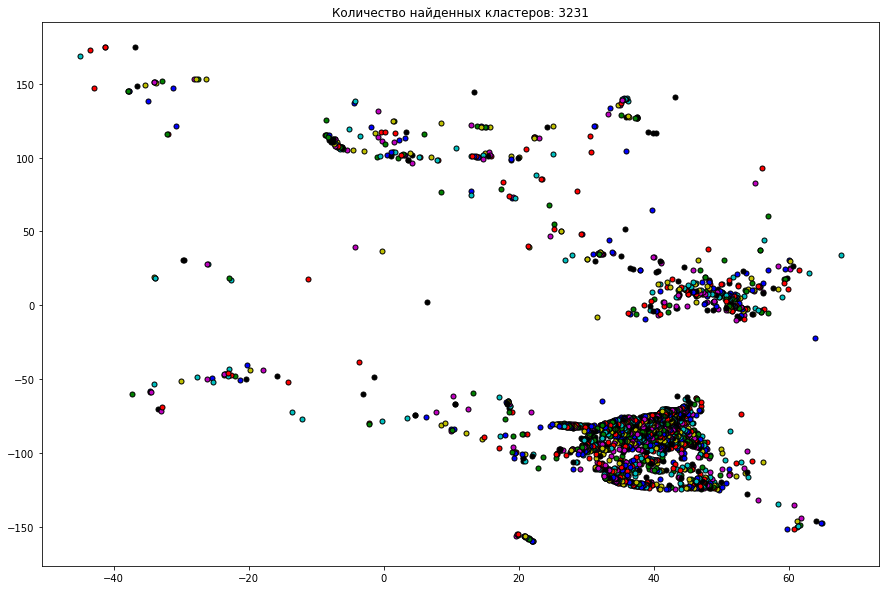

In [56]:
# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle
CentersAllData = pd.DataFrame(columns=['latitude', 'longitude', 'numbers of elements'])

plt.figure(figsize=(15,10))
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(len(labels_unique)), colors):
    cluster_center = cluster_centers[k]
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=5)
    
plt.title('Количество найденных кластеров: %d' % len(labels_unique))

plt.show()


Некоторые из получившихся кластеров содержат слишком мало точек — такие кластеры не интересны рекламодателям. Поэтому надо определить, какие из кластеров содержат, скажем, больше 15 элементов. Центры этих кластеров и являются оптимальными для размещения.

In [43]:
np.empty

<function numpy.empty>

In [45]:
#Determining the labels with counts more than 15
labels_unique_more = []
for index, cnt in enumerate(labels_counts):
    if cnt > 15:
        labels_unique_more.append(labels_unique[index])

print('Number of labels with counts more than 15: %d' % len(labels_unique_more))

Number of labels with counts more than 15: 592


In [8]:
#Determining cluster centers for the labels with counts more than 15
cluster_centers_more = np.empty( (len(labels_unique_more), 2) )
for index, lbl in enumerate(labels_unique_more):
    cluster_centers_more[index] = cluster_centers[lbl]

print(cluster_centers_more)

[[  40.7177164   -73.99183542]
 [  33.44943805 -112.00213969]
 [  33.44638027 -111.90188756]
 ...
 [  41.61853175  -88.44556818]
 [  39.2494686   -77.1821271 ]
 [  38.65877915  -76.8856871 ]]


Как мы помним, 20 баннеров надо разместить близ офисов компании. Найдем на Google Maps по запросу Carnival Cruise Line адреса всех офисов:

33.751277, -118.188740 (Los Angeles)

25.867736, -80.324116 (Miami)

51.503016, -0.075479 (London)

52.378894, 4.885084 (Amsterdam)

39.366487, 117.036146 (Beijing)

-33.868457, 151.205134 (Sydney)

Осталось определить 20 ближайших к ним центров кластеров. Т.е. посчитать дистанцию до ближайшего офиса для каждой точки и выбрать 20 с наименьшим значением.

In [10]:
#Reading the Carnival Cruise Line offices file
offices = pd.read_csv('carnival_cruise_lines_officies.txt', skipinitialspace=True)
print(offices.info())
offices_for_dist = offices.loc[:, ['latitude', 'longitude']]
offices_for_dist

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   6 non-null      float64
 1   longitude  6 non-null      float64
 2   city       6 non-null      object 
dtypes: float64(2), object(1)
memory usage: 272.0+ bytes
None


,latitude,longitude
0,33.751277,-118.188740
1,25.867736,-80.324116
2,51.503016,-0.075479
3,52.378894,4.885084
4,39.366487,117.036146
5,-33.868457,151.205134


In [11]:
def distance(x, y):
    return np.sqrt( np.sum((x - y)**2) )

In [12]:
#Calculating distances from nearest offices
distances_from_nearest_office = np.empty( cluster_centers_more.shape[0] )
for i, item in enumerate(cluster_centers_more):
    min_dist = distance(item, offices_for_dist.loc[0])
    for j in range(len(offices)):
        dist = distance(item, offices_for_dist.loc[j])
        if dist < min_dist:
            min_dist = dist
    distances_from_nearest_office[i] = min_dist

In [18]:
#Sorting arrays on minimum distance
dist_sorted_indices = np.argsort(distances_from_nearest_office)
distances_from_nearest_office_sorted = distances_from_nearest_office[dist_sorted_indices]
cluster_centers_more_sorted = cluster_centers_more[dist_sorted_indices]

Для сдачи задания выберите из получившихся 20 центров тот, который наименее удален от ближайшего к нему офиса. Ответ в этом задании — широта и долгота этого центра, записанные через пробел.

In [19]:
print('Minimal distance: %f' % distances_from_nearest_office_sorted[0])
print('Coordinates of closest centroid: %s' % str(cluster_centers_more_sorted[0]))

Minimal distance: 0.007835
Coordinates of closest centroid: [-33.86063043 151.20477593]


In [20]:
#Writing the answer to the file
answer = str(cluster_centers_more_sorted[0, 0]) + ' ' + str(cluster_centers_more_sorted[0, 1])
with open('answer.txt', 'w') as fout:
    fout.write(answer)